In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
import pathlib
import itertools as it
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import svm
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

mod_path = os.path.abspath(os.path.join('..', '..', '..'))
if mod_path not in sys.path:
    sys.path.insert(0, mod_path)

from ex6.python.libs import *

In [3]:
mpl.rcParams['figure.dpi'] = 150

In [4]:
vocab_list, vocab_pos = get_vocab_list('../../data/vocab.txt')

In [5]:
file_content = read_file('../../data/emailSample1.txt')
word_indices = process_email(file_content, vocab_pos)

In [6]:
print(word_indices)

[85, 915, 793, 1076, 882, 369, 1698, 789, 1821, 1830, 882, 430, 1170, 793, 1001, 1894, 591, 1675, 237, 161, 88, 687, 944, 1662, 1119, 1061, 1698, 374, 1161, 478, 1892, 1509, 798, 1181, 1236, 809, 1894, 1439, 1546, 180, 1698, 1757, 1895, 687, 1675, 991, 960, 1476, 70, 529, 1698, 530]


# Feature extraction

In [7]:
file_content = read_file('../../data/emailSample1.txt')
word_indices = process_email(file_content, vocab_pos)
features = email_features(word_indices, len(vocab_list))

In [8]:
print(f'Length of feature vector: {len(features)}')
print(f'Number of non-zero entries: {features.sum()}')

Length of feature vector: 1899
Number of non-zero entries: 44.0


## Train Linear SVM for Spam Classification

In [9]:
data = sio.loadmat('../../data/spamTrain.mat')
X = data['X']
y = data['y'].ravel()

In [10]:
C = 0.1
clf = svm.LinearSVC(C=C)
clf.fit(X, y)

LinearSVC(C=0.1)

In [11]:
p = clf.predict(X)
print(f'Training Accuracy: {clf.score(X, y) * 100}')

Training Accuracy: 99.97500000000001


## Test Spam Classification

In [12]:
data = sio.loadmat('../../data/spamTest.mat')
Xtest = data['Xtest']
ytest = data['ytest'].ravel()

In [13]:
p = clf.predict(Xtest)
print(f'Test Accuracy: {clf.score(Xtest, ytest) * 100}')

Test Accuracy: 99.2


## Top predictors of Spam

In [14]:
def f_importances(coef, names, k):
    imp = coef
    imp, names = zip(*sorted(zip(imp, names), reverse=True)[:k])
    fix, ax = plt.subplots()
    ax.barh(range(len(names)), imp, align='center')
    ax.set_yticks(range(len(names)), names)
    return ax

In [15]:
inpertance = permutation_importance(clf, Xtest, ytest)
sorted_idx = inpertance.importances_mean.argsort()[::-1][:15]
fig, ax = plt.subplots()
ax.barh(vocab_list[sorted_idx], inpertance.importances_mean[sorted_idx])

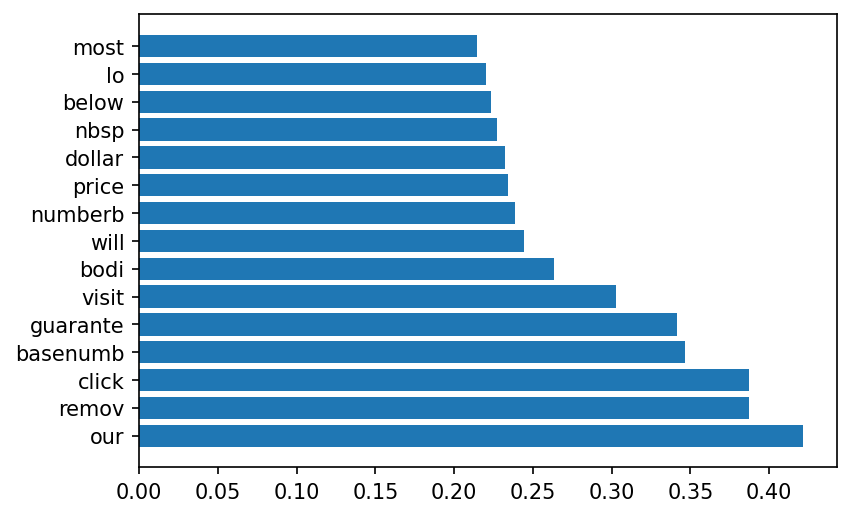

In [17]:
ax = f_importances(clf.coef_.ravel(), vocab_list, 15)

## Optional, Try your own emails

In [18]:
filenames = [
    '../../data/spamSample1.txt',
    '../../data/spamSample2.txt',
    '../../data/emailSample1.txt',
    '../../data/emailSample2.txt'
]

for filename in filenames:
    file_content = read_file(filename)
    word_indices = process_email(file_content, vocab_pos)
    x = email_features(word_indices, len(vocab_list))
    p = clf.predict(x[np.newaxis, :])
    print(f'Processed {filename}, Spam Classification: {p}')

Processed ../../data/spamSample1.txt, Spam Classification: [1]
Processed ../../data/spamSample2.txt, Spam Classification: [1]
Processed ../../data/emailSample1.txt, Spam Classification: [0]
Processed ../../data/emailSample2.txt, Spam Classification: [0]


# Optional Build your own dataset

Using the email data from *SpamAssassin Public Corpus* from [here](https://www.kaggle.com/datasets/beatoa/spamassassin-public-corpus) from stcratch to train a SVM model.

In [20]:
X = np.empty((0, len(vocab_list)))
y = np.empty(0)

In [21]:
XX, yy = load_email_data('../../data/corpus/easy_ham/easy_ham/', vocab_pos, 0, -1)
X = np.vstack((X, XX))
y = np.hstack((y, yy))

In [22]:
XX, yy = load_email_data('../../data/corpus/hard_ham/hard_ham/', vocab_pos, 0, -1)
X = np.vstack((X, XX))
y = np.hstack((y, yy))

In [23]:
XX, yy = load_email_data('../../data/corpus/spam_2/spam_2/', vocab_pos, 1, -1)
X = np.vstack((X, XX))
y = np.hstack((y, yy))

In [24]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4, shuffle=True, stratify=y, random_state=42)
Xtest, Xval, ytest, yval = train_test_split(Xtest, ytest, test_size=0.5, shuffle=True, stratify=ytest, random_state=42)

In [25]:
C = 0.1
clf = svm.SVC(kernel='linear', C=C)
clf.fit(Xtrain, ytrain)

SVC(C=0.1, kernel='linear')

In [26]:
print(f'Test Accuracy: {clf.score(Xval, yval) * 100}')

Test Accuracy: 99.04761904761905


In [27]:
print(confusion_matrix(yval, clf.predict(Xval)))
print(classification_report(yval, clf.predict(Xval)))

[[556   5]
 [  3 276]]
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       561
         1.0       0.98      0.99      0.99       279

    accuracy                           0.99       840
   macro avg       0.99      0.99      0.99       840
weighted avg       0.99      0.99      0.99       840



<BarContainer object of 15 artists>

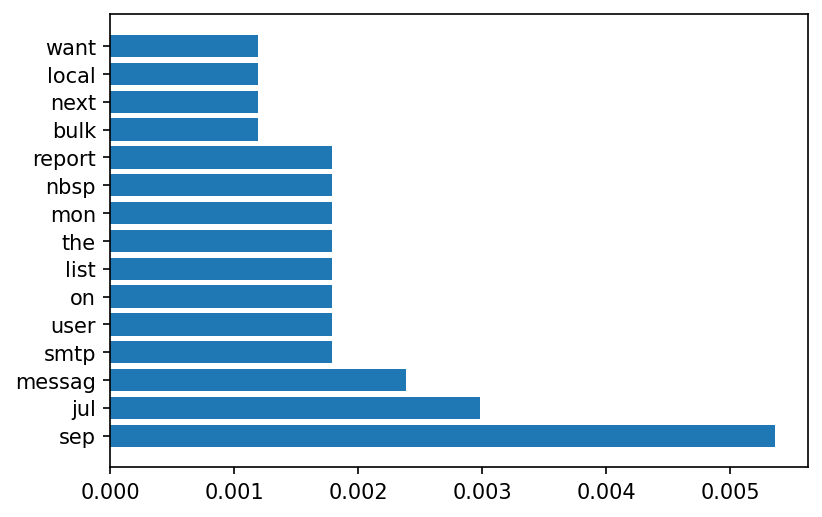

In [29]:
inpertance = permutation_importance(clf, Xval, yval, n_repeats=2)
sorted_idx = inpertance.importances_mean.argsort()[::-1][:15]
fig, ax = plt.subplots()
ax.barh(vocab_list[sorted_idx], inpertance.importances_mean[sorted_idx])